In [185]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# таблица с уникальными идентификаторами пользователей
olist_customers = pd.read_csv('olist_customers_dataset.csv')

# таблица заказов
olist_orders = pd.read_csv('olist_orders_dataset.csv')

# товарные позиции, входящие в заказы
olist_items = pd.read_csv('olist_order_items_dataset.csv')

In [186]:
# 1 задание:
# Сколько у нас пользователей, которые совершили покупку только один раз?

In [187]:
# Соединяем таблицы: с заказами и id пользователей

unique_id = olist_orders.merge(olist_customers, on='customer_id', how='left')

In [188]:
unique_id.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date                customer_unique_id  \
0           2017-10-18 00:00:00  7c396fd4830fd04220f754e42b4e5bff   
1           2018-08-13 00:00:00  af07308b275d755c9edb36a90c618231   
2           2018-09-04 00:00:00  3a653a41f6f9fc3d2a113cf8398680e8   
3           2017-12-15 00:00:00  7c142cf63193a1473d2e66489a9ae977   
4           2018-02-26 00:00:00  72632f0f9dd73dfee390c9b22eb56dd6   

   customer_zip_code_prefix            customer_city customer_state  
0                      3149                sao paulo             SP  
1                     47813                barreiras             BA  
2                     75265               vianopolis             GO  
3                     59296  sao goncalo do amarante             RN  
4                      9195              santo andre             SP

In [189]:
# Берем завершенные заказы по пользователям, при этом заказ должен быть один

unique_id.loc[unique_id['order_status'] == 'delivered'] \
    .groupby('customer_unique_id',as_index=False) \
    .agg({'order_id':'count'}) \
    .query('order_id == 1') \
    .count().order_id

90557

In [190]:
# Получаем ответ: 90557.
# То есть 90557 пользователей совершили покупку только один раз.

In [191]:
# 2 задание:
# Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [192]:
# Сначала нужно проверить таблицу на наличие дублей в колонке статуса заказа

olist_orders.groupby('order_id', as_index=False)\
    .agg({'order_status':'count'}) \
    .order_status.unique() 

array([1], dtype=int64)

In [193]:
# Проверяю типы колонок в таблице

olist_orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [194]:
# Привожу колонку к формату datetime

olist_orders.order_purchase_timestamp = pd.to_datetime(olist_orders.order_purchase_timestamp) 

In [195]:
# Проверяю еще раз

olist_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
dtype: object

In [196]:
# Ищем среднее в недоставленных заказах

avg_cancel_orders = olist_orders.query('order_status != "delivered"')\
    .groupby([pd.Grouper(freq='MS', key='order_purchase_timestamp'),'order_status'],as_index=False) \
    .agg({'order_id':'count'}) \
    .groupby('order_status',as_index=False)\
    .agg({'order_id':'mean'}) \
    .rename(columns={'order_id':'avg_value'})

In [197]:
# Вывожу полученную таблицу

avg_cancel_orders

order_status  avg_value
0     approved   1.000000
1     canceled  26.041667
2      created   1.666667
3     invoiced  14.952381
4   processing  15.842105
5      shipped  48.130435
6  unavailable  29.000000

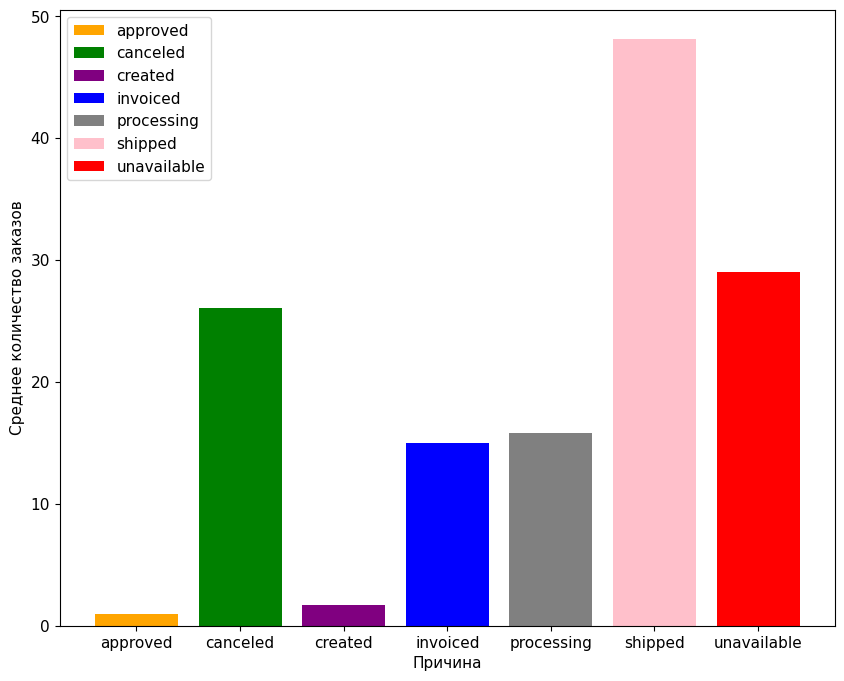

In [198]:
# Создаю цвета в графике
colors = {
    'canceled': 'green',
    'unavailable': 'red',
    'invoiced': 'blue',
    'created': 'purple',
    'approved': 'orange',
    'processing': 'gray',
    'shipped': 'pink',
}

# Строю диаграмму
fig, ax = plt.subplots(figsize=(10,8))
for i in range(len(avg_cancel_orders)):
    status = avg_cancel_orders['order_status'][i]
    value = avg_cancel_orders['avg_value'][i]
    color = colors[status]
    ax.bar(status, value, color=color, label=status)

ax.set_xlabel('Причина')
ax.set_ylabel('Среднее количество заказов')
ax.legend()

plt.show()

In [199]:
# Детализация по причинам:

# больше всего отменено покупок из-за ошибки сервиса доставки (shipped) - 48,13% 
# на втором месте (approved, created, invoiced, canceled) - отмена заказа на разных этапах заказчиком - 42,66%
# далее - это причина отсутствия товара (unavailable) - 29%
# и системный сбой (processing) - 15,84%.

In [200]:
# 3 задание:
# По каждому товару определить, в какой день недели товар чаще всего покупается.

In [201]:
# Соединяем таблицу заказов и таблицу с товарными позициями

orders_and_items = olist_orders.merge(olist_items, how='left',on='order_id') \
    [['product_id','order_purchase_timestamp','order_status']]

In [202]:
# Проверяем колонку

orders_and_items.order_purchase_timestamp.head()

0   2017-10-02 10:56:33
1   2018-07-24 20:41:37
2   2018-08-08 08:38:49
3   2017-11-18 19:28:06
4   2018-02-13 21:18:39
Name: order_purchase_timestamp, dtype: datetime64[ns]

In [203]:
# Делаю в колонке дни недели вместо даты

orders_and_items.order_purchase_timestamp = olist_orders.order_purchase_timestamp.dt.day_name()

In [204]:
orders_and_items.order_purchase_timestamp.head()

0       Monday
1      Tuesday
2    Wednesday
3     Saturday
4      Tuesday
Name: order_purchase_timestamp, dtype: object

In [205]:
# Дропаем пропущенные данные

orders_and_items = orders_and_items.dropna()

In [206]:
orders_and_items

product_id order_purchase_timestamp order_status
0      87285b34884572647811a353c7ac498a                   Monday    delivered
1      595fac2a385ac33a80bd5114aec74eb8                  Tuesday    delivered
2      aa4383b373c6aca5d8797843e5594415                Wednesday    delivered
3      d0b61bfb1de832b15ba9d266ca96e5b0                 Saturday    delivered
4      65266b2da20d04dbe00c5c2d3bb7859e                  Tuesday    delivered
...                                 ...                      ...          ...
99436  08574b074924071f4e201e151b152b4e                 Thursday    delivered
99437  4f4524396824b581a27a7dcebb2938b5                  Tuesday    delivered
99438  f777c903946dd86fd00cd5b32ec3e907                   Sunday    delivered
99439  6413f7a28e149a324c4a914000399fb2                   Monday    delivered
99440  3fbc0ef745950c7932d5f2a446189725                 Thursday    delivered

[98757 rows x 3 columns]

In [207]:
# Группируем по дням недели и указываем, что товар куплен
    
id_day = orders_and_items.query('order_status == "delivered"') \
    .groupby(['product_id','order_purchase_timestamp'],as_index=False) \
    .agg({'order_status':'count'}) \
    .drop_duplicates(subset=["product_id"], keep='first') \
    [['product_id','order_purchase_timestamp']]

In [208]:
# Выводим таблицу с id товара и днем недели, в который этот товар чаще покупается

id_day

product_id order_purchase_timestamp
0      0009406fd7479715e4bef61dd91f2462                  Tuesday
1      000b8f95fcb9e0096488278317764d19                   Friday
2      000d9be29b5207b54e86aa1b1ac54872                   Monday
3      0011c512eb256aa0dbbb544d8dffcf6e                 Saturday
4      00126f27c813603687e6ce486d909d01                   Monday
...                                 ...                      ...
57752  fff6177642830a9a94a0f2cba5e476d1                   Friday
57754  fff81cc3158d2725c0655ab9ba0f712c                 Saturday
57755  fff9553ac224cec9d15d49f5a263411f                 Saturday
57756  fffdb2d0ec8d6a61f0a0a0db3f25b441                   Monday
57759  fffe9eeff12fcbd74a2f2b007dde0c58                  Tuesday

[29786 rows x 2 columns]

In [209]:
# 4 задание:
# Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть 
# не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [210]:
# Переводим дату в название месяца

unique_id.order_purchase_timestamp = olist_orders.order_purchase_timestamp.dt.month_name()

In [211]:
# Считаю сколько недель в месяце

unique_id['weeks'] = olist_orders.order_purchase_timestamp.dt.days_in_month / 7

In [212]:
# Считаю среднее количество успешных заказов

weekly_customers = unique_id.query('order_status == "delivered"') \
    .groupby(['customer_unique_id','order_purchase_timestamp','weeks'], as_index=False) \
    .agg({'order_status':'count'}) \
    .groupby(['customer_unique_id','order_purchase_timestamp','weeks'],as_index=False) \
    .agg({'order_status':'sum'}) \
    .rename(columns={'order_purchase_timestamp':'month','order_status':'avg_orders'}) 

In [213]:
weekly_customers

customer_unique_id     month     weeks  avg_orders
0      0000366f3b9a7992bf8c76cfdf3221e2       May  4.428571           1
1      0000b849f77a49e4a4ce2b2a4ca5be3f       May  4.428571           1
2      0000f46a3911fa3c0805444483337064     March  4.428571           1
3      0000f6ccb0745a6a4b88665a16c9f078   October  4.428571           1
4      0004aac84e0df4da2b147fca70cf8255  November  4.285714           1
...                                 ...       ...       ...         ...
95150  fffcf5a5ff07b0908bd4e2dbc735a684      June  4.285714           1
95151  fffea47cd6d3cc0a88bd621562a9d061  December  4.428571           1
95152  ffff371b4d645b6ecea244b27531430a  February  4.000000           1
95153  ffff5962728ec6157033ef9805bacc48       May  4.428571           1
95154  ffffd2657e2aad2907e67c3e9daecbeb       May  4.428571           1

[95155 rows x 4 columns]

In [214]:
# Считаю среднее количество покупок в неделю (по месяцам)

weekly_customers.avg_orders = weekly_customers.avg_orders / weekly_customers.weeks

In [215]:
weekly_customers

customer_unique_id     month     weeks  avg_orders
0      0000366f3b9a7992bf8c76cfdf3221e2       May  4.428571    0.225806
1      0000b849f77a49e4a4ce2b2a4ca5be3f       May  4.428571    0.225806
2      0000f46a3911fa3c0805444483337064     March  4.428571    0.225806
3      0000f6ccb0745a6a4b88665a16c9f078   October  4.428571    0.225806
4      0004aac84e0df4da2b147fca70cf8255  November  4.285714    0.233333
...                                 ...       ...       ...         ...
95150  fffcf5a5ff07b0908bd4e2dbc735a684      June  4.285714    0.233333
95151  fffea47cd6d3cc0a88bd621562a9d061  December  4.428571    0.225806
95152  ffff371b4d645b6ecea244b27531430a  February  4.000000    0.250000
95153  ffff5962728ec6157033ef9805bacc48       May  4.428571    0.225806
95154  ffffd2657e2aad2907e67c3e9daecbeb       May  4.428571    0.225806

[95155 rows x 4 columns]

In [216]:
# 5 задание:
# Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким 
# retention на 3й месяц.

In [217]:
# Объединяю таблицы в одну и отсеиваю по статусу delivered

olist_orders_customers = olist_orders.merge(olist_customers, how='inner', on='customer_id')
delivered_orders = olist_orders_customers[olist_orders_customers.order_status == 'delivered']

# Проверяю таблицу
delivered_orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date                customer_unique_id  \
0           2017-10-18 00:00:00  7c396fd4830fd04220f754e42b4e5bff   
1           2018-08-13 00:00:00  af07308b275d755c9edb36a90c618231   
2           2018-09-04 00:00:00  3a653a41f6f9fc3d2a113cf8398680e8   
3           2017-12-15 00:00:00  7c142cf63193a1473d2e66489a9ae977   
4           2018-02-26 00:00:00  72632f0f9dd73dfee390c9b22eb56dd6   

   customer_zip_code_prefix            customer_city customer_state  
0                      3149                sao paulo             SP  
1                     47813                barreiras             BA  
2                     75265               vianopolis             GO  
3                     59296  sao goncalo do amarante             RN  
4                      9195              santo andre             SP

In [218]:
delivered_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
dtype: object

In [219]:
# Перевожу формат колонки с датой в формат с названием месяца

delivered_orders.order_purchase_timestamp = delivered_orders.order_purchase_timestamp.dt.to_period('M')

C:\Temp\ipykernel_1512\1240596317.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_orders.order_purchase_timestamp = delivered_orders.order_purchase_timestamp.dt.to_period('M')


In [220]:
# Оставляем только нужные колонки и сортируем df по дате 
    
delivered_orders = delivered_orders[['customer_unique_id','order_id','order_purchase_timestamp']]
delivered_orders = delivered_orders.sort_values('order_purchase_timestamp')
# Проверяю, что получилось
delivered_orders.head()

customer_unique_id                          order_id  \
30710  830d5b7aaa3b6f1e9ad63703bec97d23  bfbd0f9bdef84302105ad712db648a6c   
40692  2e15add79c76241beffe812a24ad3a31  cb29497c3782a76b57327c055d58b0e0   
24708  d6a930873ee3f80aa823cb1d4baca58d  0ca768c507d1fc3c61bd950bb1c5231a   
94421  f7ace36f8a10c4b2ede9ea7708e01454  2e8e21db96a8ab922e51cd297678c6b2   
53268  4a6959f9a4aca95bb3733032d0a50c9e  25f680bf746bec3df11d48318ff015de   

      order_purchase_timestamp  
30710                  2016-09  
40692                  2016-10  
24708                  2016-10  
94421                  2016-10  
53268                  2016-10

In [221]:
# Создадим столбец с месяцем первой покупки, датой первого заказа и соединим колонку с df

first_order = delivered_orders.groupby('customer_unique_id',as_index=False) \
    .agg({'order_purchase_timestamp':'first'})

In [222]:
delivered_orders = delivered_orders.merge(first_order, how='inner',on='customer_unique_id')
# Проверяю, что получилось
delivered_orders.head()

customer_unique_id                          order_id  \
0  830d5b7aaa3b6f1e9ad63703bec97d23  bfbd0f9bdef84302105ad712db648a6c   
1  2e15add79c76241beffe812a24ad3a31  cb29497c3782a76b57327c055d58b0e0   
2  d6a930873ee3f80aa823cb1d4baca58d  0ca768c507d1fc3c61bd950bb1c5231a   
3  f7ace36f8a10c4b2ede9ea7708e01454  2e8e21db96a8ab922e51cd297678c6b2   
4  4a6959f9a4aca95bb3733032d0a50c9e  25f680bf746bec3df11d48318ff015de   

  order_purchase_timestamp_x order_purchase_timestamp_y  
0                    2016-09                    2016-09  
1                    2016-10                    2016-10  
2                    2016-10                    2016-10  
3                    2016-10                    2016-10  
4                    2016-10                    2016-10

In [223]:
# Переименуем колонки order_purchase_timestamp_x и order_purchase_timestamp_y, для удобства
    
delivered_orders = delivered_orders \
.rename(columns={'order_purchase_timestamp_x':'order_date','order_purchase_timestamp_y':'first_date'})
delivered_orders.head()

customer_unique_id                          order_id  \
0  830d5b7aaa3b6f1e9ad63703bec97d23  bfbd0f9bdef84302105ad712db648a6c   
1  2e15add79c76241beffe812a24ad3a31  cb29497c3782a76b57327c055d58b0e0   
2  d6a930873ee3f80aa823cb1d4baca58d  0ca768c507d1fc3c61bd950bb1c5231a   
3  f7ace36f8a10c4b2ede9ea7708e01454  2e8e21db96a8ab922e51cd297678c6b2   
4  4a6959f9a4aca95bb3733032d0a50c9e  25f680bf746bec3df11d48318ff015de   

  order_date first_date  
0    2016-09    2016-09  
1    2016-10    2016-10  
2    2016-10    2016-10  
3    2016-10    2016-10  
4    2016-10    2016-10

In [224]:
# Группируем данные в колонках и вычисляем количество уникальных значений в столбце 'customer_unique_id' для каждой группы

delivered_orders = delivered_orders.groupby(['first_date','order_date']) \
    .agg({'customer_unique_id':'count'})

In [225]:
# Считаем когорту
    
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 1
    return df

delivered_orders = delivered_orders.groupby(level=0).apply(cohort_period)
delivered_orders.head()

customer_unique_id  cohort_period
first_date order_date                                   
2016-09    2016-09                      1              1
2016-10    2016-10                    265              1
           2017-04                      1              2
           2017-07                      1              3
           2017-09                      1              4

In [226]:
# Используем метод pivot_table для преобразования delivered_orders в сводную таблицу

delivered_orders = delivered_orders \
.pivot_table(columns='cohort_period', index = 'first_date',values='customer_unique_id')

In [227]:
# Вычисляем и находим когорту с максимальным retention

dff = delivered_orders[1]
retention = delivered_orders.divide(dff, axis=0).round(4)
retention[retention[3] == retention[3].max()].index

PeriodIndex(['2017-09'], dtype='period[M]', name='first_date')

In [228]:
# Грузим получившуюся таблицу

retention

cohort_period   1       2       3       4       5       6       7       8   \
first_date                                                                   
2016-09        1.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2016-10        1.0  0.0038  0.0038  0.0038  0.0038  0.0038  0.0038  0.0075   
2016-12        1.0  1.0000     NaN     NaN     NaN     NaN     NaN     NaN   
2017-01        1.0  0.0027  0.0027  0.0013  0.0040  0.0013  0.0040  0.0013   
2017-02        1.0  0.0018  0.0030  0.0012  0.0042  0.0012  0.0024  0.0018   
2017-03        1.0  0.0047  0.0035  0.0047  0.0035  0.0016  0.0016  0.0031   
2017-04        1.0  0.0066  0.0026  0.0022  0.0026  0.0026  0.0039  0.0031   
2017-05        1.0  0.0048  0.0045  0.0028  0.0028  0.0034  0.0045  0.0014   
2017-06        1.0  0.0052  0.0042  0.0042  0.0032  0.0039  0.0036  0.0023   
2017-07        1.0  0.0058  0.0034  0.0024  0.0034  0.0021  0.0031  0.0010   
2017-08        1.0  0.0070  0.0039  0.0027  0.0034  0.0056  0.0029  0.0027   
2017-09        1.0  0.0069  0.0054  0.0037  0.0044  0.0032  0.0022  0.0025   
2017-10        1.0  0.0075  0.0025  0.0009  0.0025  0.0021  0.0021  0.0039   
2017-11        1.0  0.0059  0.0038  0.0017  0.0017  0.0020  0.0013  0.0018   
2017-12        1.0  0.0020  0.0030  0.0037  0.0026  0.0020  0.0017  0.0002   
2018-01        1.0  0.0033  0.0036  0.0029  0.0029  0.0017  0.0017  0.0023   
2018-02        1.0  0.0034  0.0040  0.0030  0.0025  0.0022  0.0020     NaN   
2018-03        1.0  0.0039  0.0034  0.0031  0.0012  0.0012     NaN     NaN   
2018-04        1.0  0.0059  0.0030  0.0024  0.0015     NaN     NaN     NaN   
2018-05        1.0  0.0053  0.0026  0.0018     NaN     NaN     NaN     NaN   
2018-06        1.0  0.0042  0.0027     NaN     NaN     NaN     NaN     NaN   
2018-07        1.0  0.0052     NaN     NaN     NaN     NaN     NaN     NaN   
2018-08        1.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

cohort_period      9       10      11      12      13      14      15      16  \
first_date                                                                      
2016-09           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2016-10        0.0075     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2016-12           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2017-01        0.0013  0.0040  0.0013  0.0067  0.0040  0.0013  0.0013  0.0027   
2017-02        0.0012  0.0018  0.0012  0.0030  0.0012  0.0018  0.0012  0.0006   
2017-03        0.0031  0.0008  0.0035  0.0012  0.0020  0.0012  0.0016  0.0024   
2017-04        0.0031  0.0018  0.0026  0.0009  0.0004  0.0004  0.0009  0.0009   
2017-05        0.0026  0.0031  0.0026  0.0034  0.0023  0.0003  0.0017  0.0020   
2017-06        0.0013  0.0019  0.0029  0.0039  0.0016  0.0019  0.0032     NaN   
2017-07        0.0021  0.0029  0.0021  0.0031  0.0013  0.0024     NaN     NaN   
2017-08        0.0015  0.0015  0.0024  0.0019  0.0012     NaN     NaN     NaN   
2017-09        0.0027  0.0017  0.0025  0.0007     NaN     NaN     NaN     NaN   
2017-10        0.0030  0.0018  0.0021     NaN     NaN     NaN     NaN     NaN   
2017-11        0.0013  0.0006     NaN     NaN     NaN     NaN     NaN     NaN   
2017-12        0.0019     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2018-01           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2018-02           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2018-03           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2018-04           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2018-05           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2018-06           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2018-07           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2018-08           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

cohort_period      17  

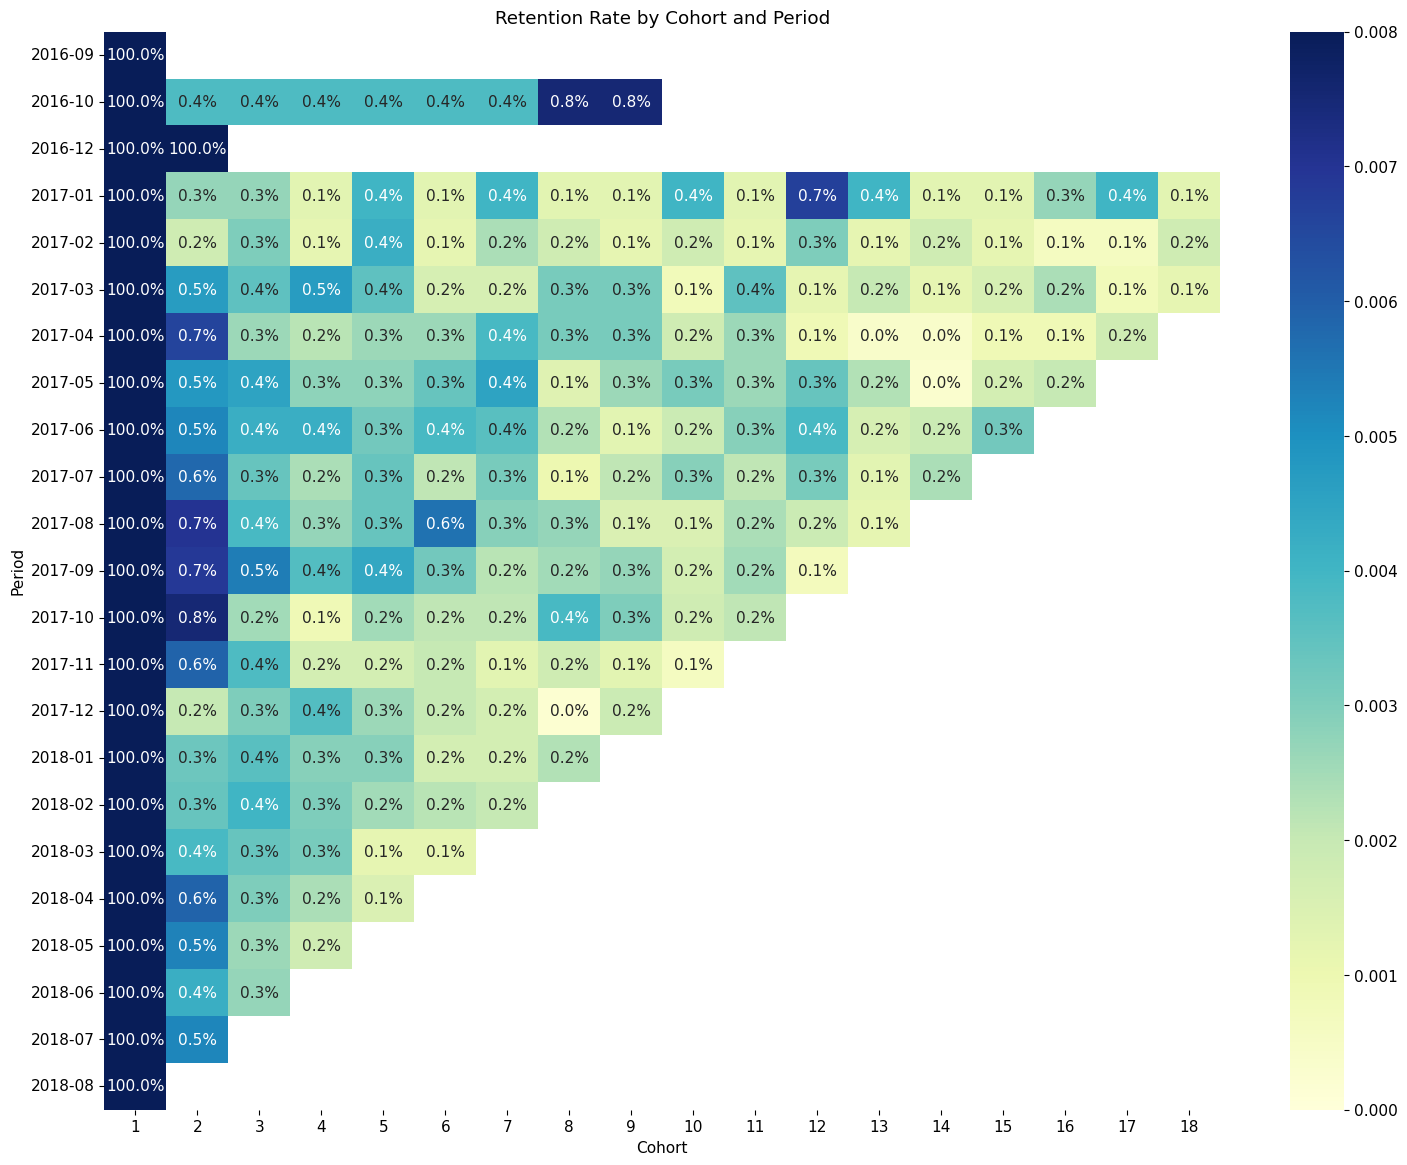

In [229]:
# График

plt.rcParams['font.size'] = '11'
plt.figure(figsize=(18,14))

ax = sns.heatmap(data=retention, annot=True, fmt='.1%', vmin=0.0, vmax=0.008, cmap='YlGnBu')
ax.set_yticklabels(retention.index, rotation=0)
ax.set_title('Retention Rate by Cohort and Period')
ax.set_xlabel('Cohort')
ax.set_ylabel('Period')

fig=ax.get_figure()
fig.savefig("Retention Counts.png")

plt.show()

In [230]:
# Задание 6:
# Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй 
# RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: 
# R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, 
# M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик 
# recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, 
# frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 
# 1780 до 3560 рублей в неделю.

In [231]:
# объединяем таблицы

df = pd.merge(olist_customers, olist_orders, on='customer_id')
olist_rfm = pd.merge(df, olist_items, on='order_id')

In [232]:
# оставляю только нужные колонки для удобства

olist_rfm = olist_rfm[olist_rfm.order_status == 'delivered']
orders_status_rfm = olist_rfm[['customer_unique_id','order_id','order_purchase_timestamp','price']]
orders_status_rfm.head()

customer_unique_id                          order_id  \
0  861eff4711a542e4b93843c6dd7febb0  00e7ee1b050b8499577073aeb2a297a1   
1  290c77bc529b7ac935b93aa66c333dc3  29150127e6685892b6eab3eec79f59c7   
2  060e732b5b29e8181a18229c7b0b2b5e  b2059ed67ce144a36e2aa97d2c9e9ad2   
3  259dac757896d24d7702b9acbbff3f3c  951670f92359f4fe4a63112aa7306eba   
4  345ecd01c38d18a9036ed96c73b8d066  6b7d50bd145f6fc7f33cebabd7e49d0f   

  order_purchase_timestamp   price  
0      2017-05-16 15:05:35  124.99  
1      2018-01-12 20:48:24  289.00  
2      2018-05-19 16:07:45  139.94  
3      2018-03-13 16:06:38  149.94  
4      2018-07-29 09:51:30  230.00

In [233]:
orders_status_rfm.dtypes

customer_unique_id                  object
order_id                            object
order_purchase_timestamp    datetime64[ns]
price                              float64
dtype: object

In [234]:
orders_status_rfm.order_purchase_timestamp = pd.to_datetime(orders_status_rfm.order_purchase_timestamp)

C:\Temp\ipykernel_1512\3242219097.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_status_rfm.order_purchase_timestamp = pd.to_datetime(orders_status_rfm.order_purchase_timestamp)


In [235]:
# Разница между текущей датой и датой последнего заказа

orders_status_rfm['time_delta'] = orders_status_rfm.order_purchase_timestamp \
    - orders_status_rfm.order_purchase_timestamp.max()
orders_status_rfm.head()

C:\Temp\ipykernel_1512\1238357523.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_status_rfm['time_delta'] = orders_status_rfm.order_purchase_timestamp \


customer_unique_id                          order_id  \
0  861eff4711a542e4b93843c6dd7febb0  00e7ee1b050b8499577073aeb2a297a1   
1  290c77bc529b7ac935b93aa66c333dc3  29150127e6685892b6eab3eec79f59c7   
2  060e732b5b29e8181a18229c7b0b2b5e  b2059ed67ce144a36e2aa97d2c9e9ad2   
3  259dac757896d24d7702b9acbbff3f3c  951670f92359f4fe4a63112aa7306eba   
4  345ecd01c38d18a9036ed96c73b8d066  6b7d50bd145f6fc7f33cebabd7e49d0f   

  order_purchase_timestamp   price          time_delta  
0      2017-05-16 15:05:35  124.99 -470 days +00:04:58  
1      2018-01-12 20:48:24  289.00 -229 days +05:47:47  
2      2018-05-19 16:07:45  139.94 -102 days +01:07:08  
3      2018-03-13 16:06:38  149.94 -169 days +01:06:01  
4      2018-07-29 09:51:30  230.00  -32 days +18:50:53

In [236]:
# Делаю сегмент r-score и создаю значения (меньше 30 дней, до 96 дней и больше 96 дней)

orders_status_rfm['r_score'] = pd.qcut(orders_status_rfm['time_delta'],q = [0,0.8,0.9,1] , labels=[1,2,3])
orders_status_rfm.head()

C:\Temp\ipykernel_1512\605807098.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_status_rfm['r_score'] = pd.qcut(orders_status_rfm['time_delta'],q = [0,0.8,0.9,1] , labels=[1,2,3])


customer_unique_id                          order_id  \
0  861eff4711a542e4b93843c6dd7febb0  00e7ee1b050b8499577073aeb2a297a1   
1  290c77bc529b7ac935b93aa66c333dc3  29150127e6685892b6eab3eec79f59c7   
2  060e732b5b29e8181a18229c7b0b2b5e  b2059ed67ce144a36e2aa97d2c9e9ad2   
3  259dac757896d24d7702b9acbbff3f3c  951670f92359f4fe4a63112aa7306eba   
4  345ecd01c38d18a9036ed96c73b8d066  6b7d50bd145f6fc7f33cebabd7e49d0f   

  order_purchase_timestamp   price          time_delta r_score  
0      2017-05-16 15:05:35  124.99 -470 days +00:04:58       1  
1      2018-01-12 20:48:24  289.00 -229 days +05:47:47       1  
2      2018-05-19 16:07:45  139.94 -102 days +01:07:08       1  
3      2018-03-13 16:06:38  149.94 -169 days +01:06:01       1  
4      2018-07-29 09:51:30  230.00  -32 days +18:50:53       3

In [237]:
# Соединяю таблицу и r

unique_id = olist_orders.merge(olist_customers, on='customer_id', how='left') 
unique_id.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date                customer_unique_id  \
0           2017-10-18 00:00:00  7c396fd4830fd04220f754e42b4e5bff   
1           2018-08-13 00:00:00  af07308b275d755c9edb36a90c618231   
2           2018-09-04 00:00:00  3a653a41f6f9fc3d2a113cf8398680e8   
3           2017-12-15 00:00:00  7c142cf63193a1473d2e66489a9ae977   
4           2018-02-26 00:00:00  72632f0f9dd73dfee390c9b22eb56dd6   

   customer_zip_code_prefix            customer_city customer_state  
0                      3149                sao paulo             SP  
1                     47813                barreiras             BA  
2                     75265               vianopolis             GO  
3                     59296  sao goncalo do amarante             RN  
4                      9195              santo andre             SP

In [238]:
# Считаю сколько заказов у каждого пользователя

x = unique_id[unique_id['order_status'] == 'delivered'] \
    .groupby('customer_unique_id')['order_id'].count() \
    .reset_index(name='count')

In [239]:
# Удаляю дубликаты и пропуски

orders_status_rfm.customer_unique_id = orders_status_rfm.customer_unique_id.drop_duplicates()
orders_status_rfm = orders_status_rfm.dropna()

C:\Temp\ipykernel_1512\3104163563.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_status_rfm.customer_unique_id = orders_status_rfm.customer_unique_id.drop_duplicates()


In [240]:
# Соединяю колонки и проверяю таблицу

orders_status_rfm = orders_status_rfm.merge(x,how='left', on='customer_unique_id')
orders_status_rfm.head()

customer_unique_id                          order_id  \
0  861eff4711a542e4b93843c6dd7febb0  00e7ee1b050b8499577073aeb2a297a1   
1  290c77bc529b7ac935b93aa66c333dc3  29150127e6685892b6eab3eec79f59c7   
2  060e732b5b29e8181a18229c7b0b2b5e  b2059ed67ce144a36e2aa97d2c9e9ad2   
3  259dac757896d24d7702b9acbbff3f3c  951670f92359f4fe4a63112aa7306eba   
4  345ecd01c38d18a9036ed96c73b8d066  6b7d50bd145f6fc7f33cebabd7e49d0f   

  order_purchase_timestamp   price          time_delta r_score  count  
0      2017-05-16 15:05:35  124.99 -470 days +00:04:58       1      1  
1      2018-01-12 20:48:24  289.00 -229 days +05:47:47       1      1  
2      2018-05-19 16:07:45  139.94 -102 days +01:07:08       1      1  
3      2018-03-13 16:06:38  149.94 -169 days +01:06:01       1      1  
4      2018-07-29 09:51:30  230.00  -32 days +18:50:53       3      1

In [241]:
# Делаю сегмент по количеству заказов от 1-го до 3-х (в третьем 3 и больше)

orders_status_rfm['f_score'] = orders_status_rfm['count'].apply(lambda x: 3 if x > 2 else x)
orders_status_rfm.head()

customer_unique_id                          order_id  \
0  861eff4711a542e4b93843c6dd7febb0  00e7ee1b050b8499577073aeb2a297a1   
1  290c77bc529b7ac935b93aa66c333dc3  29150127e6685892b6eab3eec79f59c7   
2  060e732b5b29e8181a18229c7b0b2b5e  b2059ed67ce144a36e2aa97d2c9e9ad2   
3  259dac757896d24d7702b9acbbff3f3c  951670f92359f4fe4a63112aa7306eba   
4  345ecd01c38d18a9036ed96c73b8d066  6b7d50bd145f6fc7f33cebabd7e49d0f   

  order_purchase_timestamp   price          time_delta r_score  count  f_score  
0      2017-05-16 15:05:35  124.99 -470 days +00:04:58       1      1        1  
1      2018-01-12 20:48:24  289.00 -229 days +05:47:47       1      1        1  
2      2018-05-19 16:07:45  139.94 -102 days +01:07:08       1      1        1  
3      2018-03-13 16:06:38  149.94 -169 days +01:06:01       1      1        1  
4      2018-07-29 09:51:30  230.00  -32 days +18:50:53       3      1        1

In [242]:
# Резальтат

orders_status_rfm.f_score.value_counts()

1    90557
2     2573
3      228
Name: f_score, dtype: int64

In [243]:
# Сортирую по заказам и считаю сумму по пользователям

olist_orders_delivered = olist_orders[olist_orders['order_status'] == 'delivered']
y = olist_rfm.groupby('customer_unique_id')['price'].sum().reset_index(name='sum_price')
y.head()

customer_unique_id  sum_price
0  0000366f3b9a7992bf8c76cfdf3221e2     129.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f      18.90
2  0000f46a3911fa3c0805444483337064      69.00
3  0000f6ccb0745a6a4b88665a16c9f078      25.99
4  0004aac84e0df4da2b147fca70cf8255     180.00

In [244]:
# Разбиваем на 3 группы по сумме: 3) от 154, 2) от 89.73, 1) остальные

y['m_score'] = pd.cut(y['sum_price'], bins=[-np.inf, 89.73, 154, np.inf], labels=[1, 2, 3])
y.head()

customer_unique_id  sum_price m_score
0  0000366f3b9a7992bf8c76cfdf3221e2     129.90       2
1  0000b849f77a49e4a4ce2b2a4ca5be3f      18.90       1
2  0000f46a3911fa3c0805444483337064      69.00       1
3  0000f6ccb0745a6a4b88665a16c9f078      25.99       1
4  0004aac84e0df4da2b147fca70cf8255     180.00       3

In [247]:
# Соединяем M-score с таблицей

orders_status_rfm = orders_status_rfm.merge(y, how='left', on='customer_unique_id')

In [248]:
# Оставим в таблице только нужные колонки

orders_status_rfm = orders_status_rfm[['customer_unique_id','r_score','f_score','m_score']]
orders_status_rfm.head()

customer_unique_id r_score  f_score m_score
0  861eff4711a542e4b93843c6dd7febb0       1        1       2
1  290c77bc529b7ac935b93aa66c333dc3       1        1       3
2  060e732b5b29e8181a18229c7b0b2b5e       1        1       2
3  259dac757896d24d7702b9acbbff3f3c       1        1       2
4  345ecd01c38d18a9036ed96c73b8d066       3        1       3

In [249]:
# Добавляю RFM

orders_status_rfm['RFM'] = orders_status_rfm[['r_score', 'f_score', 'm_score']].apply(lambda x: ''.join(x.astype(str)), axis=1)
orders_status_rfm.head()

customer_unique_id r_score  f_score m_score  RFM
0  861eff4711a542e4b93843c6dd7febb0       1        1       2  112
1  290c77bc529b7ac935b93aa66c333dc3       1        1       3  113
2  060e732b5b29e8181a18229c7b0b2b5e       1        1       2  112
3  259dac757896d24d7702b9acbbff3f3c       1        1       2  112
4  345ecd01c38d18a9036ed96c73b8d066       3        1       3  313

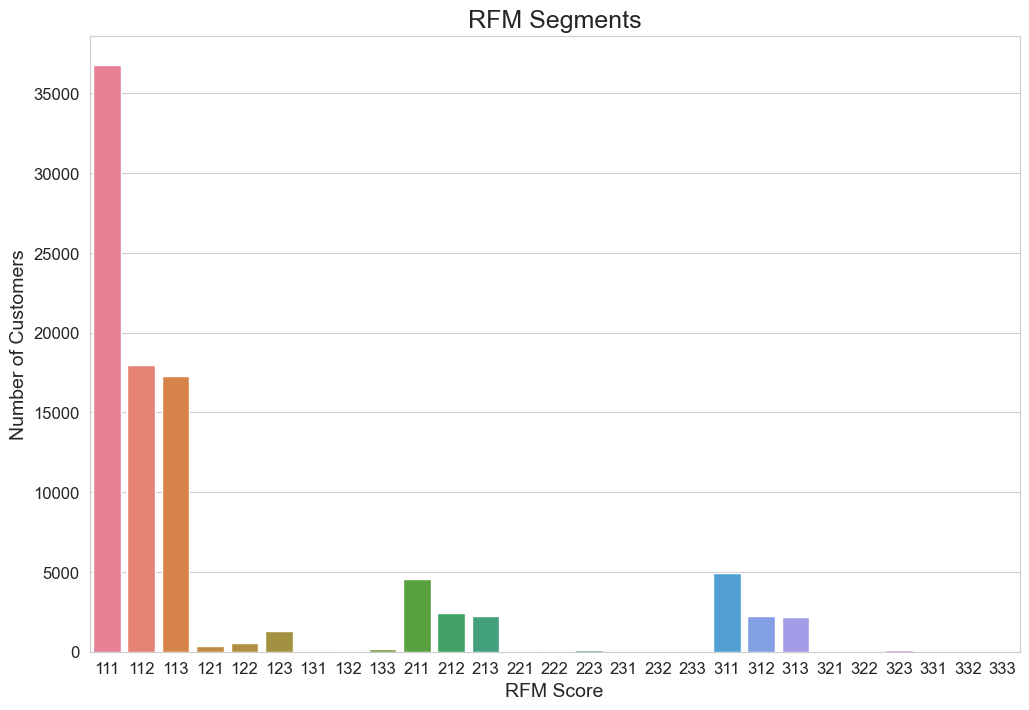

In [256]:
# Данные для графика
result = orders_status_rfm.groupby('RFM',as_index=False) \
    .agg({'customer_unique_id':'count'})

# Создаю график
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.barplot(data=result, x='RFM', y='customer_unique_id', palette="husl")

# Добавляею подписи осей и заголовок графика
plt.xlabel('RFM Score', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.title('RFM Segments', fontsize=18)

# Устанавливаю размер шрифта на осях
plt.tick_params(labelsize=12)
plt.show()

In [276]:
# Таблица с процентами

result = result.sort_values('customer_unique_id', ascending=False)
result['percent'] = round((result['customer_unique_id'] * 100) / result['customer_unique_id'].sum(), 2).astype(str) + ' %'
result.head()

RFM  customer_unique_id  percent  RFM_score
0   111               36779   39.4 %        111
1   112               17968  19.25 %        112
2   113               17273   18.5 %        113
18  311                4906   5.26 %        311
9   211                4536   4.86 %        211

In [277]:
result.dtypes

RFM                   object
customer_unique_id     int64
percent               object
RFM_score              int32
dtype: object

In [278]:
result['RFM_score'] = result['RFM'].astype(int)

In [279]:
result.dtypes

RFM                   object
customer_unique_id     int64
percent               object
RFM_score              int32
dtype: object

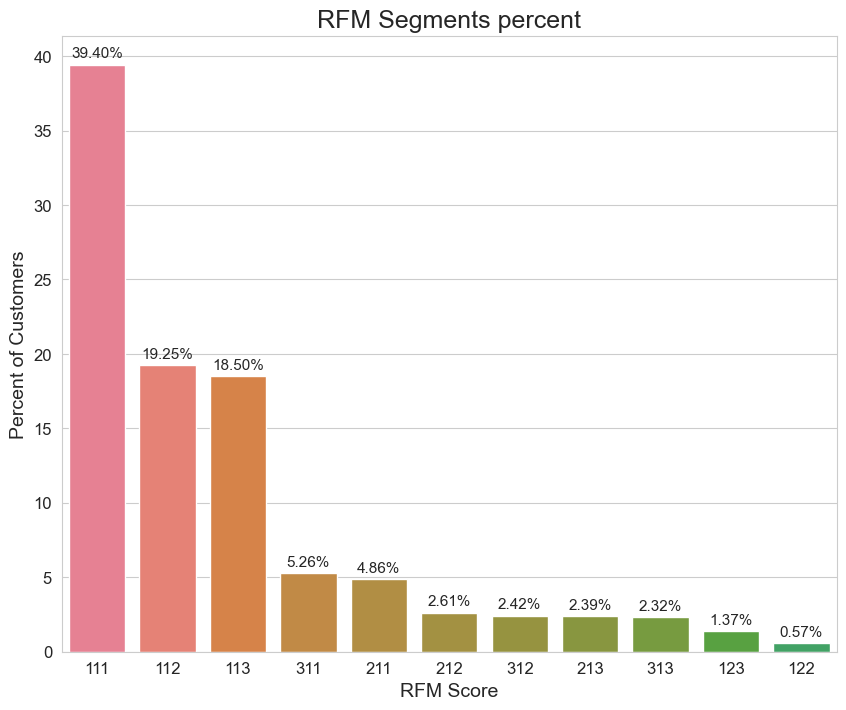

In [283]:
# Создаю столбец 'percent_numeric'
result['percent_numeric'] = result['percent'].str[:-2].astype(float)

# График
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
# (выведем до 0.50%)
ax = sns.barplot(data=result[result['percent_numeric'] > 0.5], x='RFM', y='percent_numeric', palette=colors)

# Подписи
plt.xlabel('RFM Score', fontsize=14)
plt.ylabel('Percent of Customers', fontsize=14)
plt.title('RFM Segments percent', fontsize=18)

plt.tick_params(labelsize=12)

# Добавляю проценты над столбцами
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%', xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.show()